In [ ]:
import pandas as pd
from transformers import RobertaModel, RobertaTokenizer, RobertaConfig
from triagerx.dataset.text_processor import TextProcessor
import torch

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/data/google_chromium/classifier_data_20.csv"
df = pd.read_csv(dataset_path)
df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df[df["owner"].notna()]

num_cv = 10
block = 9
# sample_threshold=20 # Threshold to filter developers
samples_per_block = len(df) // num_cv

sliced_df = df[: samples_per_block * (block + 1)]
df_train = sliced_df[: samples_per_block * block]
df_test = sliced_df[samples_per_block * block : samples_per_block * (block + 1)]

sample_threshold = 20
developers = df_train["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
df_train = df_train[df_train["owner"].isin(filtered_developers)]

train_owners = set(df_train["owner"])
test_owners = set(df_test["owner"])

unwanted = list(test_owners - train_owners)

df_test = df_test[~df_test["owner"].isin(unwanted)]

lbl2idx = {}
idx2lbl = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx
    idx2lbl[idx] = dev

df_train["owner_id"] = df_train["owner"].apply(lambda owner: lbl2idx[owner])
df_test["owner_id"] = df_test["owner"].apply(lambda owner: lbl2idx[owner])
df_test = TextProcessor.prepare_dataframe(df_test, False, False, True, False, False)

print(f"Training data: {len(df_train)}, Validation data: {len(df_test)}")
print(f"Number of train developers: {len(df_train.owner.unique())}")
print(f"Number of test developers: {len(df_test.owner.unique())}")

100%|██████████| 10781/10781 [00:00<00:00, 1168172.55it/s]
2024-11-01 17:15:45.510 | INFO     | triagerx.dataset.text_processor:prepare_dataframe:58 - Cleaning text...
100%|██████████| 10781/10781 [00:01<00:00, 5590.70it/s]
2024-11-01 17:15:47.443 | INFO     | triagerx.dataset.text_processor:prepare_dataframe:71 - Adding description...
100%|██████████| 10781/10781 [00:00<00:00, 115418.25it/s]

Training data: 98165, Validation data: 10781
Number of train developers: 986
Number of test developers: 857


In [4]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
import numpy as np

class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: RobertaTokenizer,
        feature: str = "text",
        target: str = "owner_id",
        max_tokens: int = 256,
    ):
        print("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        print("Tokenizing texts...")
        self.texts = [
            self.tokenizer(
                row[feature],
                padding="max_length",
                max_length=max_tokens,
                truncation=True,
                return_tensors="pt",
            )
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [5]:
import numpy as np
import pandas as pd
from loguru import logger
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel
from triagerx.dataset.text_processor import TextProcessor


def process_data_for_triagerx(
        text,
        model: PredictionModel,
        max_length: int = 256,
        device="cuda"
    ):
        
        text = TextProcessor.clean_text(text)

        tokenizer1 = model.tokenizer(0)
        tokenizer2 = model.tokenizer(1)

        tok1 = tokenizer1(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids1 = tok1["input_ids"].to(device)
        mask1 = tok1["attention_mask"].to(device)
        
        
        tok2 = tokenizer2(
                    text,
                    padding="max_length",
                    max_length=max_length,
                    truncation=True,
                    return_tensors="pt",
                )
        
        input_ids2 = tok2["input_ids"].to(device)
        mask2 = tok2["attention_mask"].to(device)

        return input_ids1, mask1, input_ids2, mask2


In [6]:
import torch
import torch.nn as nn

device="cuda"

class LBTPClassifier(nn.Module):
    def __init__(
        self,
        embedding_model,
        output_size,
        unfrozen_layers=1,
        num_classifiers=3,
        max_tokens=256,
    ) -> None:
        super().__init__()
        self.base_model = embedding_model

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, self.base_model.config.num_hidden_layers - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = max_tokens
        self._num_classifiers = num_classifiers
        self._embed_size = embedding_model.config.hidden_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, self._embed_size)),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        self.classifier_weights = nn.Parameter(torch.ones(self._num_classifiers))

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(
                    len(filter_sizes) * self._num_filters + self._embed_size,
                    output_size,
                )
                for _ in range(self._num_classifiers)
            ]
        )

        # Dropout is ommitted as it is not mentioned in the LBTP paper
        # self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None):
        # input_ids = input["input_ids"].squeeze(1).to(device)
        # attention_mask = input["attention_mask"].squeeze(1).to(device)

        outputs = []

        base_out = self.base_model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

        # print(base_out.attentions)
        
        pooler_out = base_out.pooler_output.squeeze(0)
        
        if len(pooler_out.shape) == 1:
            pooler_out = pooler_out.unsqueeze(0)
            
        hidden_states = base_out.hidden_states[-self._num_classifiers :]

        for i in range(self._num_classifiers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]  
            x = torch.cat(x, dim=1)
            x = torch.cat([pooler_out, x], dim=1)
            x = self.classifier_weights[i] * self.classifiers[i](x)

            outputs.append(x)

        return outputs

In [8]:
# print("Load pretrained embedding model")
# model_config = RobertaConfig.from_pretrained("roberta-large")
# model_config.num_hidden_layers = 3
# model_config.output_hidden_states = True
# embedding_model = RobertaModel(model_config)
# embedding_model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/distillation/lbtp_gc_base.pt"))
# print("Loaded weights from the saved state.")

# tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# model = LBTPClassifier(embedding_model, output_size=len(df_train.owner_id.unique()))
# model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/lbtp_dt_gc/lbtp_gc_block9.pt"))

In [7]:
import torch
from loguru import logger
from torch import nn
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizer,
)

from triagerx.model.prediction_model import PredictionModel


class FCNTransformer(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        dropout=0.1,
        base_model="microsoft/deberta-large",
        max_tokens=512,
        label_map=None,
    ) -> None:
        super(FCNTransformer, self).__init__()
        self.base_model = AutoModelForSequenceClassification.from_pretrained(
            base_model, num_labels=output_size
        )
        self._tokenizer = AutoTokenizer.from_pretrained(base_model)
        self._label_map = label_map

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            logger.debug(
                f"Freezing {self.base_model.config.num_hidden_layers - unfrozen_layers} layers"
            )
            # Freeze embedding layers
            for p in self.base_model.embeddings.parameters():
                p.requires_grad = False

            # Freeze encoder layers till last {unfrozen_layers} layers
            for i in range(
                0, self.base_model.config.num_hidden_layers - unfrozen_layers
            ):
                for p in self.base_model.encoder.layer[i].parameters():
                    p.requires_grad = False

    def forward(self, input_ids, attention_mask=None):
        # inputs = {
        #     key: value.squeeze(1).to(next(self.parameters()).device)
        #     for key, value in inputs.items()
        # }

        base_out = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

        return base_out.logits

    def tokenizer(self) -> PreTrainedTokenizer:
        return self._tokenizer

    def tokenize_text(self, text):
        return self._tokenizer(
            text,
            padding="max_length",
            max_length=self._max_tokens,
            truncation=True,
            return_tensors="pt",
        )

    def get_label_map(self):
        return self._label_map

In [8]:
import torch
from loguru import logger
from torch import nn
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel


class CNNTransformer(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        num_classifiers,
        dropout=0.1,
        base_model="microsoft/deberta-large",
        max_tokens=512,
        num_filters=256,
        label_map=None,
    ) -> None:
        super(CNNTransformer, self).__init__()
        self.base_model = AutoModel.from_pretrained(
            base_model, output_hidden_states=True
        )
        self._tokenizer = AutoTokenizer.from_pretrained(base_model)
        self._label_map = label_map

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            logger.debug(
                f"Freezing {self.base_model.config.num_hidden_layers - unfrozen_layers} layers"
            )
            # Freeze embedding layers
            for p in self.base_model.embeddings.parameters():
                p.requires_grad = False

            # Freeze encoder layers till last {unfrozen_layers} layers
            for i in range(
                0, self.base_model.config.num_hidden_layers - unfrozen_layers
            ):
                for p in self.base_model.encoder.layer[i].parameters():
                    p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = num_filters
        self._num_classifiers = num_classifiers
        self._max_tokens = max_tokens
        self._embed_size = self.base_model.config.hidden_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, self._embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                nn.Linear(len(filter_sizes) * self._num_filters, output_size)
                for _ in range(self._num_classifiers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None):
        # inputs = {
        #     key: value.squeeze(1).to(next(self.parameters()).device)
        #     for key, value in inputs.items()
        # }
        outputs = []

        base_out = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # pooler_out = base_out.last_hidden_state.squeeze(0)
        hidden_states = base_out.hidden_states[-self._num_classifiers :]

        for i in range(self._num_classifiers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            # Concatanating outputs of the conv block of different filter sizes
            feature_map = torch.cat(x, dim=1)
            x = self.dropout(feature_map)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> PreTrainedTokenizer:
        return self._tokenizer

    def tokenize_text(self, text):
        return self._tokenizer(
            text,
            padding="max_length",
            max_length=self._max_tokens,
            truncation=True,
            return_tensors="pt",
        )

    def get_label_map(self):
        return self._label_map


In [20]:

print("Load pretrained embedding model")
model_config = RobertaConfig.from_pretrained("roberta-large")
model_config.num_hidden_layers = 3
model_config.output_hidden_states = True
embedding_model = RobertaModel(model_config)
embedding_model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/distillation/lbtp_gc_base.pt"))
print("Loaded weights from the saved state.")

lbtp_tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

model_lbtp = LBTPClassifier(embedding_model, output_size=len(df_train.owner_id.unique()))
model_lbtp.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/distillation/lbtp_gc_block9.pt"))

Load pretrained embedding model
Loaded weights from the saved state.


<All keys matched successfully>

In [12]:
base_model_name = "roberta-large"

model = CNNTransformer(output_size=len(df_train.owner_id.unique()), unfrozen_layers=-1, num_classifiers=1, dropout=0.1, base_model=base_model_name, max_tokens=256)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/deeptriage/roberta-large-full_dt_gc_th20_block9_seed42.pt"))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-11-01 17:19:34.175 | DEBUG    | __main__:__init__:29 - Initiating full training...


<All keys matched successfully>

In [13]:
# base_model_name = "roberta-large"

# model = FCNTransformer(output_size=len(df_train.owner_id.unique()), unfrozen_layers=-1, dropout=0.1, base_model=base_model_name, max_tokens=256)
# model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/deeptriage/gc_fcn_roberta-large-full_dt_th20_block9_seed42.pt"))
# tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [13]:
import torch
from loguru import logger
from torch import nn
from transformers import AutoModel, AutoTokenizer, PreTrainedTokenizer

from triagerx.model.prediction_model import PredictionModel


class TriagerxModel(PredictionModel):
    def __init__(
        self,
        output_size,
        unfrozen_layers,
        num_classifiers,
        base_models,
        dropout=0.1,
        max_tokens=512,
        num_filters=256,
        label_map=None,
    ) -> None:
        super(TriagerxModel, self).__init__()

        # Initialize base models and their respective tokenizers
        logger.debug(f"Loading base transformer models: {base_models}")
        self.base_models = nn.ModuleList(
            [
                AutoModel.from_pretrained(model, output_hidden_states=True)
                for model in base_models
            ]
        )
        self.tokenizers = [
            AutoTokenizer.from_pretrained(model) for model in base_models
        ]
        self._label_map = label_map

        if unfrozen_layers == -1:
            logger.debug("Initiating full training...")
        else:
            # Freeze embedding layers for all models
            for base_model in self.base_models:
                logger.debug(
                    f"Freezing {base_model.config.num_hidden_layers - unfrozen_layers} layers"
                )
                for p in base_model.embeddings.parameters():
                    p.requires_grad = False

            # Freeze encoder layers until the last `unfrozen_layers` layers for all models
            for base_model in self.base_models:
                for i in range(
                    0, base_model.config.num_hidden_layers - unfrozen_layers
                ):
                    for p in base_model.encoder.layer[i].parameters():
                        p.requires_grad = False

        # Define filter sizes for convolution layers
        filter_sizes = [3, 4, 5, 6]
        self._num_filters = num_filters
        self._num_classifiers = num_classifiers
        self._max_tokens = max_tokens
        self.unfrozen_layers = unfrozen_layers

        # Calculate total embedding size by summing hidden sizes of all base models
        embed_sizes = [base_model.config.hidden_size for base_model in self.base_models]
        self._embed_size = sum(embed_sizes)

        # Initialize convolutional blocks for each classifier
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(
                                1,
                                self._num_filters,
                                (K, self._embed_size),
                            ),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(self._num_classifiers)
            ]
        )

        # Initialize classifiers for each classifier block
        self.classifiers = nn.ModuleList(
            [
                nn.Linear(len(filter_sizes) * self._num_filters, output_size)
                for _ in range(self._num_classifiers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

        # Initialize learnable weights for each base model
        self.model_weights = nn.ParameterList(
            [nn.Parameter(torch.ones(self._num_classifiers)) for _ in self.base_models]
        )
        self.classifier_weights = nn.Parameter(torch.ones(self._num_classifiers))

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        # Process input data for each base model
        # inputs = [
        #     {
        #         key: value.squeeze(1).to(next(self.parameters()).device)
        #         for key, value in model_inputs.items()
        #     }
        #     for model_inputs in inputs
        # ]

        hidden_states = []

        # Extract hidden states from each base model
        for idx, base_model in enumerate(self.base_models):
            ids = None
            mask = None

            if idx == 0:
                ids = input_ids1
                mask = attention_mask1

            if idx == 1:
                ids = input_ids2
                mask = attention_mask2


            base_out = base_model(
                input_ids=ids,
                attention_mask=mask,
            )
            hidden_states.append(base_out.hidden_states[-self._num_classifiers :])

        outputs = []

        # Concatenate hidden states and apply convolutional blocks and classifiers
        for i in range(self._num_classifiers):
            # Apply learnable weights to hidden states from each base model
            weighted_hidden_states = [
                self.model_weights[idx][i] * hidden_states[idx][i]
                for idx in range(len(self.base_models))
            ]
            concatenated_hidden_states = torch.cat(weighted_hidden_states, dim=-1)
            batch_size, sequence_length, hidden_size = concatenated_hidden_states.size()
            x = [
                conv(
                    concatenated_hidden_states.view(
                        batch_size, 1, sequence_length, hidden_size
                    )
                )
                for conv in self.conv_blocks[i]
            ]
            # Concatenating outputs of the convolutional blocks of different filter sizes
            feature_map = torch.cat(x, dim=1)
            x = self.dropout(feature_map)
            x = self.classifier_weights[i] * self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self, model_idx) -> PreTrainedTokenizer:
        # Return the tokenizer for the specified base model index
        if model_idx < 0 or model_idx >= len(self.tokenizers):
            raise ValueError(
                f"Invalid model index, choose between 0 and {len(self.tokenizers) - 1}"
            )
        return self.tokenizers[model_idx]

    def tokenize_text(self, text):
        return [
            tokenizer(
                text,
                padding="max_length",
                max_length=self._max_tokens,
                truncation=True,
                return_tensors="pt",
            )
            for tokenizer in self.tokenizers
        ]

    def get_label_map(self):
        return self._label_map


In [14]:
triagerx_model = TriagerxModel(
    output_size=len(df_train.owner.unique()),
    unfrozen_layers=3,
    num_classifiers=3,
    base_models=["microsoft/deberta-base", "roberta-base"],
    dropout=0.2,
    max_tokens=256,
    num_filters=256,
    label_map=None,
)

2024-11-01 17:19:57.409 | DEBUG    | __main__:__init__:24 - Loading base transformer models: ['microsoft/deberta-base', 'roberta-base']
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2024-11-01 17:19:59.221 | DEBUG    | __main__:__init__:41 - Freezing 9 layers
2024-11-01 17:19:59.223 | DEBUG    | __main__:__init__:41 - Freezing 9 layers


In [15]:
import torch

In [16]:
triagerx_model.load_state_dict(torch.load("/work/disa_lab/projects/triagerx/models/deeptriage/triagerx_ensemble_dt_gc_th20_block9_seed42.pt"))

<All keys matched successfully>

In [17]:
triagerx_model = triagerx_model.cuda()

In [21]:
def clean_data(df):
    df["text2"] = df.apply(
        lambda x: str(x["issue_title"]) + "\n" + str(x["description"]),
        axis=1,
    )
    df["text2"] = df["text2"].str.replace(
        "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        " ",
        regex=True,
    )
    df["text2"] = df["text2"].str.replace("[^A-Za-z0-9 ]+", " ", regex=True)
    df["text2"] = df["text2"].str.replace(" +", " ", regex=True)

    min_length = 15
    df = df[df["text2"].str.len().gt(min_length)]

    return df

df_test = clean_data(df_test)

In [22]:
# Define model output
def model_output(inputs):
  model.eval()
  output = model(inputs)
  return torch.sum(torch.stack(output), 0)
  # return output

def model_output_lbtp(inputs):
  model_lbtp.eval()
  output = model_lbtp(inputs)
  return torch.sum(torch.stack(output), 0)

# Define model input
model_input = model.base_model.embeddings
lbtp_model_input = model_lbtp.base_model.embeddings

In [23]:
# Define model output
def model_output_triagerx(id1, m1, id2, m2):
  model.eval()
  output = triagerx_model(id1, m1, id2, m2)
  return torch.sum(torch.stack(output), 0)

# Define model input
triagerx_model_input = [triagerx_model.base_models[0].embeddings, triagerx_model.base_models[1].embeddings]

In [24]:
from captum.attr import LayerIntegratedGradients

lig = LayerIntegratedGradients(model_output, model_input)

In [25]:
triagerx_lig = LayerIntegratedGradients(model_output_triagerx, triagerx_model_input)

/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


In [26]:
lbtp_lig = LayerIntegratedGradients(model_output_lbtp, lbtp_model_input)

In [27]:
def get_data(owner_id, sample_index):
    sample = df_test[df_test["owner_id"] == owner_id].iloc[sample_index]

    return sample.owner, sample.text, sample.text2

In [28]:
def construct_input_and_baseline_triagerx(text):

    max_length = 256
    baseline_token_id1 = triagerx_model.tokenizer(0).pad_token_id 
    baseline_token_id2 = triagerx_model.tokenizer(1).pad_token_id 
    # sep_token_id = tokenizer.sep_token_id 
    # cls_token_id = tokenizer.cls_token_id 

    id1, m1, id2, m2 = process_data_for_triagerx(text, triagerx_model, max_length=max_length)
   
    # input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = triagerx_model.tokenizer(0).convert_ids_to_tokens(id1.squeeze())
    token_list2 = triagerx_model.tokenizer(1).convert_ids_to_tokens(id1.squeeze())

    print("Tok 1: ", token_list)
    print("Tok 2:", token_list2)

    baseline1 = [baseline_token_id1] * max_length
    baseline2 = [baseline_token_id2] * max_length

    print("Baseline 1:", baseline1)
    print("Baseline 2:", baseline2)
    
    return id1, m1, id2, m2, baseline1, baseline2, token_list

In [29]:
def construct_input_and_baseline(text, tokenizer):

    max_length = 254
    baseline_token_id = tokenizer.pad_token_id 
    sep_token_id = tokenizer.sep_token_id 
    cls_token_id = tokenizer.cls_token_id 

    text_ids = tokenizer.encode(text, max_length=max_length, padding="max_length", truncation=True, add_special_tokens=False)
   
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    token_list = tokenizer.convert_ids_to_tokens(input_ids)

    baseline_input_ids = [cls_token_id] + [baseline_token_id] * len(text_ids) + [sep_token_id]
    return torch.tensor([input_ids], device='cpu'), torch.tensor([baseline_input_ids], device='cpu'), token_list

In [30]:
sum([torch.tensor([[1, 2]]), torch.tensor([[3, 4]])])

tensor([[4, 6]])

In [31]:
def summarize_attributions_triagerx(attributions):
    # print("Shape 1:", attributions[0].shape)
    # print("Shape 2:", attributions[1].shape)
    # print("Shape 3:", sum(attributions).shape)

    # print("Attributions 1: ", attributions[0][:10])
    # print("Attributions 2: ", attributions[1][:10])

    # attributions = attributions[0] + attributions[1]
    # print("Attributions sum: ", attributions[:10])

    attributions = attributions.sum(dim=-1).squeeze(0)
    print("Attributions squeeze: ", attributions[:10])
    print("Attributions shape: ", attributions.shape)
    attributions = attributions / torch.norm(attributions)
    
    return attributions

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    
    return attributions

# attributions_sum = summarize_attributions(attributions)
# print(attributions_sum.size())

In [32]:
def plot_attribution(attributions_sum, all_tokens):
    attributions_sum = attributions_sum.cpu().numpy()
    
    top_indices = np.argsort(attributions_sum)[-10:]
    # print(attributions_sum)
    # print(top_indices)

    # Filter tokens and attributions to keep only the top 10
    top_tokens = [all_tokens[i] for i in top_indices]
    top_attributions = attributions_sum[top_indices]

    # Sort top tokens and attributions for better visualization
    sorted_indices = np.argsort(top_attributions)
    top_tokens = [top_tokens[i] for i in sorted_indices]
    top_attributions = top_attributions[sorted_indices]

    # Plot attributions with highlighting
    fig, ax = plt.subplots(figsize=(8, 5))  # Increased figure size
    norm = plt.Normalize(top_attributions.min(), top_attributions.max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])

    bars = ax.bar(range(len(top_tokens)), top_attributions, color=plt.cm.coolwarm(norm(top_attributions)), alpha=0.7)
    ax.set_xticks(range(len(top_tokens)))
    ax.set_xticklabels(top_tokens, rotation=90, fontsize=12)  # Increased font size
    ax.set_xlabel('Tokens', fontsize=14)  # Increased font size
    ax.set_ylabel('Attribution', fontsize=14)  # Increased font size
    ax.set_title('Top 10 Token Attributions for Text Classification', fontsize=16)  # Increased font size

    # Add a color bar to indicate the intensity of attributions
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Attribution Intensity', fontsize=14)  # Increased font size

    # Save the plot as an image file
    plt.tight_layout()
    plt.savefig('saliency_map_top10_highlighted_large.png', dpi=300)
    plt.show()

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_attributions(attributions_sum, all_tokens, output_file='saliency_text_highlight.png'):
    """
    Generates and saves a plot with tokens highlighted based on their attribution intensity,
    using both a bar plot and a highlighted plot with a color bar.

    Args:
        attributions_sum (np.array): The summed attributions for each token.
        all_tokens (list of str): All tokens in the input text.
        output_file (str): The file path to save the plot.
    """
    # Plot attributions with bar plot
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Adjust x and y tick font size and font family
    plt.xticks(fontname='serif', fontsize=10)
    plt.yticks(fontname='serif', fontsize=10)
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(attributions_sum.min(), attributions_sum.max())
    bars = ax.bar(range(len(all_tokens)), attributions_sum[:len(all_tokens)], color=cmap(norm(attributions_sum[:len(all_tokens)])), alpha=0.8)
    ax.set_xticks(range(len(all_tokens)))
    ax.set_xticklabels(all_tokens, rotation=90)
    ax.set_xlabel('Tokens', fontname='serif', fontsize=12)
    ax.set_ylabel('Attribution', fontname='serif', fontsize=12)
    # ax.set_title('Token Attributions')

    # Add a color bar to indicate the intensity of attributions
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, fraction=0.01, pad=0.02)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('Attribution Intensity', fontname='serif', fontsize=10)

    # Save the plot as an image file
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

In [34]:
from IPython.core.display import HTML
from IPython.display import display
import numpy as np

def highlight_text(tokens, attr_scores, width=5, line_height=1.2):
    # Normalize attribute scores
    attr_scores = attr_scores / np.max(np.abs(attr_scores))

    # Generate HTML with highlighted text
    html_content = f'<div style="max-width: {width}in; line-height: {line_height}; border: gray solid 2px; padding: 5px; padding-right: 3px; border-radius: 5px">'
    for token, score in zip(tokens, attr_scores):
        if score < 0:
            color = f"rgba(255, 0, 0, {abs(score)})"
        else:
            color = f"rgba(0, 128, 0, {abs(score)})"

        html_content += f'<span style="background-color:{color}; color: black; padding: 2px;">{token}</span>' + "\n"

    html_content += '</div>'
    
    return html_content

In [35]:
from captum.attr import visualization as viz

def interpret_text(text, true_class, tokenizer, lig):
    input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text, tokenizer)
    input_ids = input_ids.to(device)
    baseline_input_ids = baseline_input_ids.to(device)
    attributions, delta = lig.attribute(inputs= input_ids,
                                    baselines= baseline_input_ids,
                                    return_convergence_delta=True,
                                    internal_batch_size=1,
                                    target=true_class
                                    )
    attributions_sum = summarize_attributions(attributions)

    attributions_sum = attributions_sum.cpu().numpy()
    # attributions_sum = attributions_sum /np.max(attributions_sum)

    filtered_attribution_sum = []
    filtered_tokens = []

    # print(len(attributions_sum))
    # print(len(all_tokens))

    for token, sum in zip(all_tokens, attributions_sum):
        if token != tokenizer.pad_token and token != tokenizer.sep_token and token != tokenizer.cls_token:
            filtered_attribution_sum.append(sum)
            filtered_tokens.append(token)

    filtered_attribution_sum = np.array(filtered_attribution_sum)

    plot_token_attributions(filtered_attribution_sum, filtered_tokens, "saliency_map_lbtp.pdf")

    score_vis = viz.VisualizationDataRecord(
                    word_attributions = filtered_attribution_sum,
                    pred_prob = torch.max(model_output(input_ids)[0]),
                    pred_class = torch.argmax(model_output(input_ids)[0]).cpu().numpy(),
                    true_class = true_class,
                    attr_class = text,
                    attr_score = filtered_attribution_sum.sum(),       
                    raw_input_ids = filtered_tokens,
                    convergence_score = delta)

    viz.visualize_text([score_vis])

    return filtered_tokens, filtered_attribution_sum

In [36]:
from captum.attr import visualization as viz
import matplotlib.pyplot as plt

def interpret_text_triagerx(text, true_class, tokenizer_id=0):
    id1, m1, id2, m2, baseline1, baseline2, all_tokens = construct_input_and_baseline_triagerx(text)
    baseline1 = torch.tensor([baseline1]).to(device)
    baseline2 = torch.tensor([baseline2]).to(device)
    attributions, delta = triagerx_lig.attribute(inputs=(id1, m1, id2, m2),
                                    baselines= (baseline1, baseline1, baseline1, baseline1),
                                    return_convergence_delta=True,
                                    internal_batch_size=1,
                                    target=true_class
                                    )
    attributions2, delta2 = triagerx_lig.attribute(inputs=(id1, m1, id2, m2),
                                    baselines= (baseline2, baseline2, baseline2, baseline2),
                                    return_convergence_delta=True,
                                    internal_batch_size=1,
                                    target=true_class
                                    )
    
    attributions_sum = sum(attributions) + sum(attributions2)
    delta = delta + delta2
    
    print("Attributions:", attributions[0])
    print("Length:", len(attributions))
    print("Attributions 2:", attributions2[1])
    print("Length:", len(attributions))
    attributions_sum = summarize_attributions_triagerx(attributions_sum)

    attributions_sum = attributions_sum.cpu().numpy()

    # attributions_sum = attributions_sum /np.max(attributions_sum)

    filtered_attribution_sum = []
    filtered_tokens = []

    # print(len(attributions_sum))
    # print(len(all_tokens))

    for token, sum_ in zip(all_tokens, attributions_sum):
        if token != triagerx_model.tokenizer(tokenizer_id).pad_token and token != triagerx_model.tokenizer(tokenizer_id).sep_token and token != triagerx_model.tokenizer(tokenizer_id).cls_token:
            filtered_attribution_sum.append(sum_)
            filtered_tokens.append(token)

    filtered_attribution_sum = np.array(filtered_attribution_sum)

    score_vis = viz.VisualizationDataRecord(
                    word_attributions = filtered_attribution_sum,
                    pred_prob = torch.max(model_output_triagerx(id1, m1, id2, m2)[0]),
                    pred_class = torch.argmax(model_output_triagerx(id1, m1, id2, m2)[0]).cpu().numpy(),
                    true_class = true_class,
                    attr_class = text,
                    attr_score = filtered_attribution_sum.sum(),       
                    raw_input_ids = filtered_tokens,
                    convergence_score = delta)

    viz.visualize_text([score_vis])

    plot_token_attributions(filtered_attribution_sum, filtered_tokens, "saliency_map_triagerx.pdf")

    return filtered_tokens, filtered_attribution_sum


In [37]:
model = model.to(device)
model_lbtp = model_lbtp.to(device)

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
# plt.rcParams["text.usetex"] = False

def plot_token_attributions_combined(attributions_model1, attributions_model2, tokens_model1, tokens_model2, output_file='saliency_text_highlight.png'):
    """
    Generates and saves a plot with tokens highlighted based on their attribution intensity
    from two different models, using different color maps for easy comparison.

    Args:
        attributions_model1 (np.array): The summed attributions for each token from the first model.
        attributions_model2 (np.array): The summed attributions for each token from the second model.
        tokens_model1 (list of str): All tokens in the input text for the first model.
        tokens_model2 (list of str): All tokens in the input text for the second model.
        output_file (str): The file path to save the plot.
    """
    # Plot attributions with bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Adjust x and y tick font size and font family
    plt.xticks(fontname='serif', fontsize=10)
    plt.yticks(fontname='serif', fontsize=10)
    
    # First model attributes
    cmap1 = plt.cm.coolwarm
    norm1 = plt.Normalize(attributions_model1.min(), attributions_model1.max())
    bars1 = ax.bar(range(len(tokens_model1)), attributions_model1[:len(tokens_model1)], color="purple", alpha=0.6, label='TriagerX')
    
    # Second model attributes
    cmap2 = plt.cm.viridis
    norm2 = plt.Normalize(attributions_model2.min(), attributions_model2.max())
    bars2 = ax.bar(range(len(tokens_model2)), attributions_model2[:len(tokens_model2)], color="orangered", alpha=0.6, label='LBT-P')

    # Set x-ticks and labels
    ax.set_xticks(range(max(len(tokens_model1), len(tokens_model2))))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax.set_xticklabels(tokens_model1, rotation=90)
    ax.set_xlabel('Tokens', fontname='serif', fontsize=16)
    ax.set_ylabel('Attribution', fontname='serif', fontsize=16)
    ax.legend()
    
    # # Add color bars
    # cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap1, norm=norm1), ax=ax, fraction=0.01, pad=0.02)
    # cbar1.ax.tick_params(labelsize=8)
    # cbar1.set_label('Model 1 Attribution Intensity', fontname='serif', fontsize=10)
    
    # cbar2 = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap2, norm=norm2), ax=ax, fraction=0.01, pad=0.08)
    # cbar2.ax.tick_params(labelsize=8)
    # cbar2.set_label('Model 2 Attribution Intensity', fontname='serif', fontsize=10)

    # Save the plot as an image file
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()


In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_attributions_grouped(attributions_model1, attributions_model2, attributions_model3, tokens_model1, tokens_model2, tokens_model3, output_file='saliency_grouped_bar_chart.png'):
    """
    Generates and saves a grouped bar chart with tokens highlighted based on their attribution intensity
    from three different models, using different colors for easy comparison.

    Args:
        attributions_model1 (np.array): The summed attributions for each token from the first model.
        attributions_model2 (np.array): The summed attributions for each token from the second model.
        attributions_model3 (np.array): The summed attributions for each token from the third model.
        tokens_model1 (list of str): All tokens in the input text for the first model.
        tokens_model2 (list of str): All tokens in the input text for the second model.
        tokens_model3 (list of str): All tokens in the input text for the third model.
        output_file (str): The file path to save the plot.
    """
    # Check that the tokens lists match
    if tokens_model1 != tokens_model2 or tokens_model1 != tokens_model3:
        raise ValueError("Token lists must be identical for a grouped comparison.")

    # Set positions and width for bars
    x = np.arange(len(tokens_model1))
    width = 0.25  # Decrease width to accommodate an extra model

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars for each model
    bars1 = ax.bar(x - width, attributions_model1[:len(tokens_model1)], width, color="purple", alpha=0.6, label='TriagerX')
    bars2 = ax.bar(x, attributions_model2[:len(tokens_model2)], width, color="orangered", alpha=0.6, label='LBT-P')
    bars3 = ax.bar(x + width, attributions_model3[:len(tokens_model3)], width, color="green", alpha=0.6, label='CodeBERT')

    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(tokens_model1, rotation=90)
    ax.set_xlabel('Tokens', fontname='serif', fontsize=16)
    ax.set_ylabel('Attribution', fontname='serif', fontsize=16)
    ax.legend()

    # Adjust font sizes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot as an image file
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

# Example usage (ensure attributions and tokens match in length):
# plot_token_attributions_grouped(attributions_model1, attributions_model2, attributions_model3, tokens_model1, tokens_model2, tokens_model3)


In [38]:
device = "cuda"

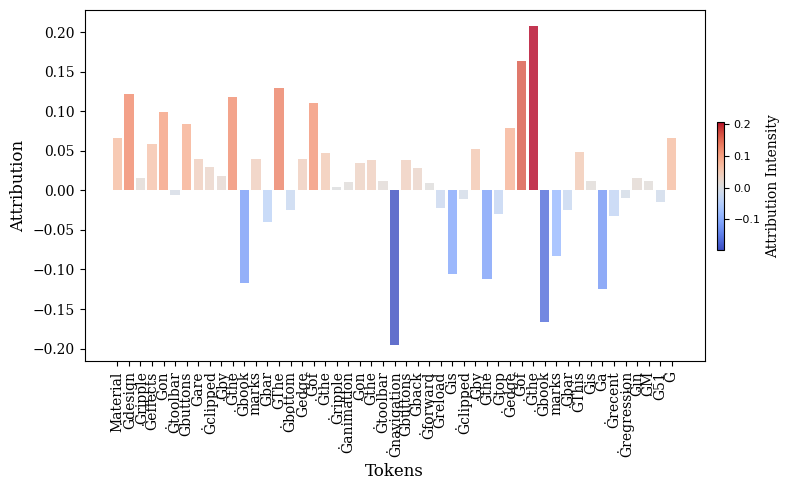

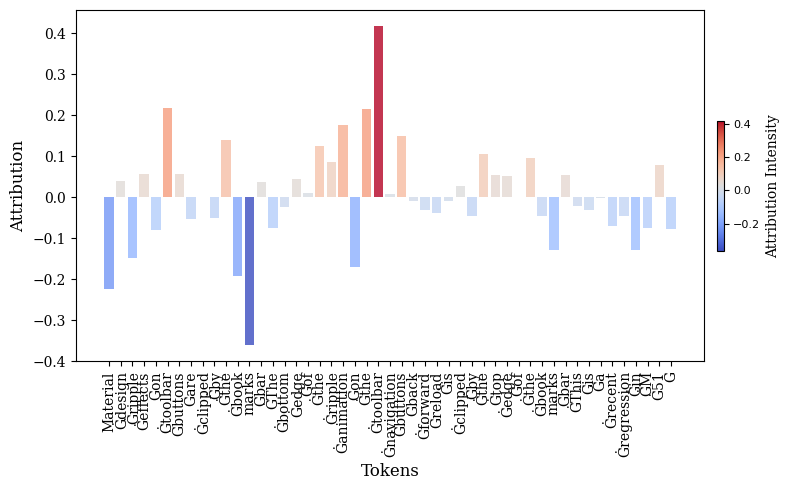

In [40]:
owner_id = 113
test_data_index = 3
owner, text, text2 = get_data(owner_id, test_data_index)
filtered_tok_roberta, filtered_attribution_roberta = interpret_text(text2, owner_id, tokenizer, lig)
filtered_tok_lbtp, filtered_attribution_lbtp = interpret_text(text2, owner_id, lbtp_tokenizer, lbtp_lig)


In [43]:
# triagerx_tokens = []
# triagerx_tokens_attr = []

# for tok1, attr in zip(filtered_tok_triagex, filtered_attribution_triagerx):
#     tok1 = tok1.replace("Ġ", "")
#     tok1 = tok1.replace("Ċ", "")
#     if tok1.strip() in skip_list:
#         continue
#     triagerx_tokens.append(tok1)
#     triagerx_tokens_attr.append(attr)
    

In [44]:
skip_list = ["Bug", "Title", "Description", ":", ",", ".", "(", ")", "-", "", "on", "are", "the", "The", "this", "a", "is", "in", "by", "of"]

In [46]:
lbtp_tokens = []
lbtp_tokens_attr = []

for tok1, attr in zip(filtered_tok_lbtp, filtered_attribution_lbtp):
    tok1 = tok1.replace("Ġ", "")
    if tok1.strip() in skip_list:
        continue
    lbtp_tokens.append(tok1)
    lbtp_tokens_attr.append(attr)
    

In [49]:
codebert_tokens = []
codebert_tokens_attr = []

for tok1, attr in zip(filtered_tok_roberta, filtered_attribution_roberta):
    tok1 = tok1.replace("Ġ", "")
    if tok1.strip() in skip_list:
        continue
    codebert_tokens.append(tok1)
    codebert_tokens_attr.append(attr)
    

In [50]:
# import json

# with open("token_attribution.json", "w") as f:
#     json.dump({
#         "trx_token_attr": triagerx_tokens_attr,
#         "lbtp_token_attr": lbtp_tokens_attr,
#         "bert_token_attr": codebert_tokens_attr,
#         "tokens": triagerx_tokens,        
#     }, f, indent=2)

In [51]:
import seaborn as sns

def plot_token_attributions_heatmap(attributions_model1, attributions_model2, attributions_model3, tokens):
    """
    Generates and saves a heatmap for model attributions.

    Args:
        attributions_model1 (np.array): Attributions from the first model.
        attributions_model2 (np.array): Attributions from the second model.
        attributions_model3 (np.array): Attributions from the third model.
        tokens (list of str): Tokens in the input text.
    """
    data = np.array([attributions_model1[:len(tokens)], attributions_model2[:len(tokens)], attributions_model3[:len(tokens)]]).T

    plt.figure(figsize=(12, 6))
    sns.heatmap(data, annot=True, cmap="YlGnBu", xticklabels=['TriagerX', 'LBT-P', 'CodeBERT'], yticklabels=tokens, cbar_kws={'label': 'Attribution'})

    plt.xlabel('Models', fontname='serif', fontsize=16)
    plt.ylabel('Tokens', fontname='serif', fontsize=16)
    plt.title('Attribution Heatmap', fontname='serif', fontsize=18)
    plt.show()


In [ ]:
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_token_attributions_heatmap(attributions_list, model_labels, tokens, correct_predictions):
    """
    Generates and displays a heatmap for model attributions, with color-coded markers for correct or incorrect predictions.

    Args:
        attributions_list (list of np.array): List of attribution arrays from different models.
        model_labels (list of str): List of labels for each model in the heatmap legend.
        tokens (list of str): Tokens in the input text.
        correct_predictions (list of bool): List indicating whether each model made a correct prediction (True) or incorrect (False).
    """
    # Generate modified labels based on prediction correctness
    modified_labels = [
        f"{label} ✓" if correct else f"{label} ✗"
        for label, correct in zip(model_labels, correct_predictions)
    ]
    
    # Ensure all attribution arrays are truncated to match the length of tokens
    data = np.array([attributions[:len(tokens)] for attributions in attributions_list]).T

    plt.figure(figsize=(12, 5))
    ax = sns.heatmap(data, annot=True, cmap="YlOrRd", xticklabels=modified_labels, annot_kws={"size": 8}, yticklabels=tokens, cbar_kws={'label': 'Attribution', 'shrink': 0.5})

    # Color code the x-tick labels based on correctness
    for tick_label, correct in zip(ax.get_xticklabels(), correct_predictions):
        color = 'green' if correct else 'red'
        tick_label.set_color(color)

    plt.xlabel('Models', fontname='serif', fontsize=14)
    plt.ylabel('Tokens', fontname='serif', fontsize=14)
    # plt.title('Attribution Heatmap', fontname='serif', fontsize=18)
    plt.show()

In [9]:
with open("token_attribution_all.json", "r") as f:
    json_data = json.load(f)

In [10]:
json_data.keys()

dict_keys(['trx_token_attr', 'bert_token_attr', 'deberta_token_attr', 'roberta_token_attr', 'codebert_token_attr', 'lbtp_token_attr', 'tokens'])

In [11]:
model_labels = ["TriagerX", "BERT", "DeBERTa", "RoBERTa", "CodeBERT", "LBT-P"]
attributions_data = [json_data[key] for key in list(json_data.keys())[:-1]]
predictions = [True, True, False, False, False, False]

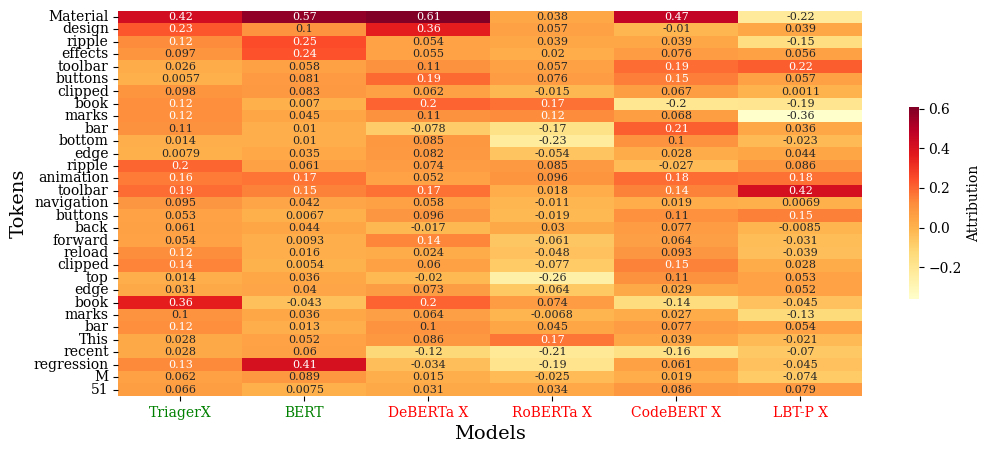

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# Set serif font
plt.rcParams["font.family"] = "serif"
font_path = "/home/mdafifal.mamun/notebooks/triagerX/times.ttf"
if font_path:
    font_manager.fontManager.addfont(font_path)
    plt.rcParams["font.sans-serif"] = "Times New Roman"
    
plot_token_attributions_heatmap(attributions_data, model_labels, json_data["tokens"], predictions)

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

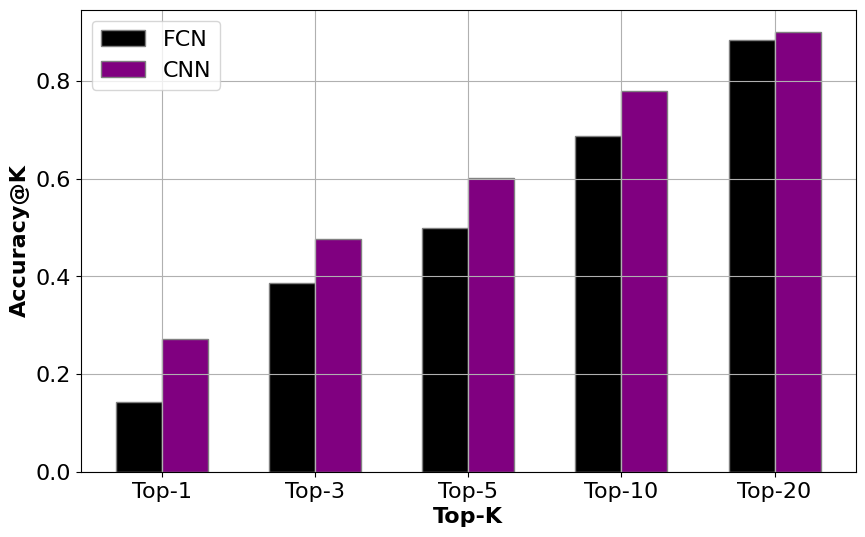

In [59]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

# Data
methods = ['Top-1', 'Top-3', 'Top-5', 'Top-10', 'Top-20']
fcn_accuracies = [0.143, 0.387, 0.5, 0.688, 0.884]
cnn_accuracies = [0.272, 0.476, 0.601, 0.780, 0.901]

# Bar width
bar_width = 0.15

# Positions of the bars on the x-axis with reduced space between groups
r1 = np.arange(len(methods)) * 0.5
r2 = [x + bar_width for x in r1]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.bar(r1, fcn_accuracies, color='black', width=bar_width, edgecolor='gray', label='FCN')
ax.bar(r2, cnn_accuracies, color='purple', width=bar_width, edgecolor='gray', label='CNN')

# Adding labels and title
ax.set_xlabel('Top-K', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy@K', fontweight='bold', fontsize=16)
ax.set_xticks([r + bar_width / 2 for r in r1])
ax.set_xticklabels(methods, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize=16)
ax.grid(True)

plt.savefig('cnn-vs-fcn.pdf', bbox_inches='tight', pad_inches=0)
# Show plot
plt.show()


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

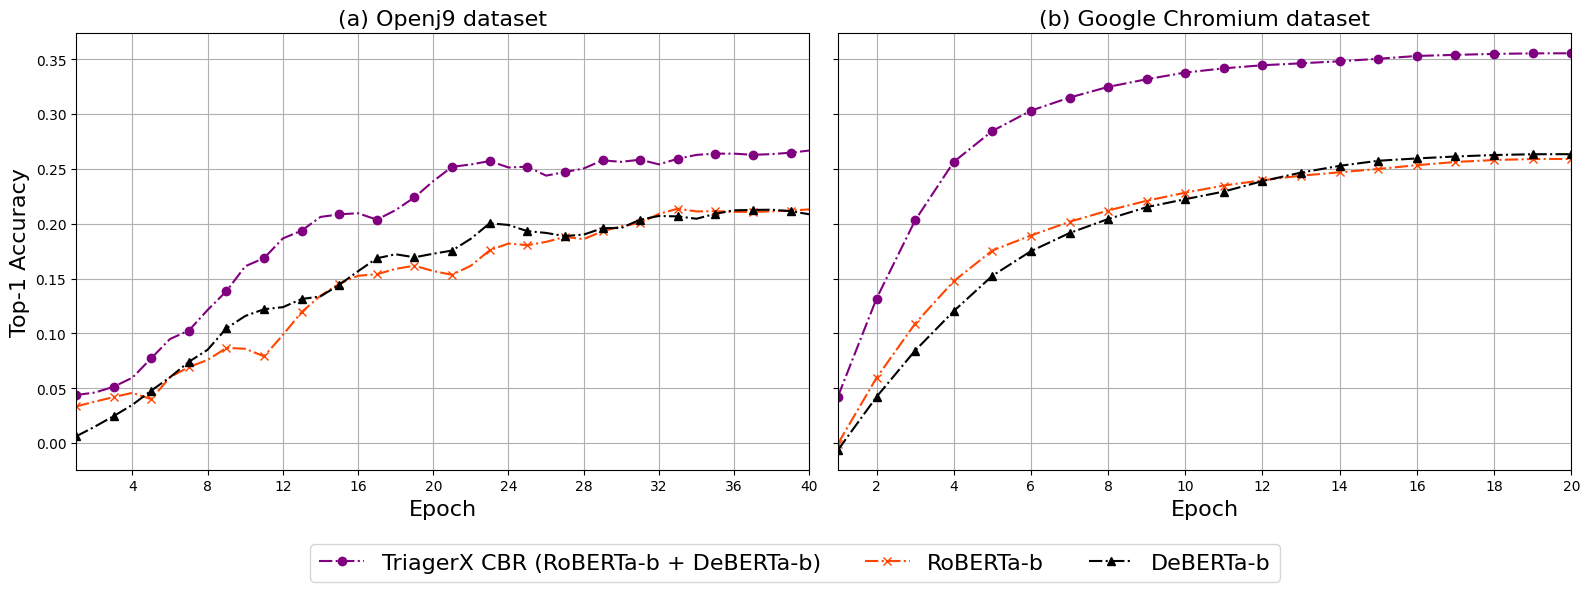

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.ticker as mticker

# Load and preprocess the first dataset
df1 = pd.read_csv("orthogonality.csv")
df1 = df1[["Step", "cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc", 
           "triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc", 
           "cnn_deberta-base_u3_50_classes_most_seed42 - val_acc"]]
df1["Step"] = df1["Step"] + 1
epochs1 = df1['Step']
u3c3_1 = savgol_filter(df1['cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2_1 = savgol_filter(df1['triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u1c1_1 = savgol_filter(df1['cnn_deberta-base_u3_50_classes_most_seed42 - val_acc'], window_length=7, polyorder=2)

# Load and preprocess the second dataset
df2 = pd.read_csv("gc_base_models.csv")
df2 = df2[["Step", "cnn_roberta_base_dt_gc_th20_block9_seed42 - val_acc", 
           "triagerx_nosampler_ensemble_dt_gc_th20_block9_seed42 - val_acc", 
           "cnn_deberta_base_dt_gc_th20_block9_seed42 - val_acc"]]
df2["Step"] = df2["Step"] + 1
epochs2 = df2['Step']
u3c3_2 = savgol_filter(df2['cnn_roberta_base_dt_gc_th20_block9_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2_2 = savgol_filter(df2['triagerx_nosampler_ensemble_dt_gc_th20_block9_seed42 - val_acc'], window_length=7, polyorder=2)
u1c1_2 = savgol_filter(df2['cnn_deberta_base_dt_gc_th20_block9_seed42 - val_acc'], window_length=7, polyorder=2)

# Plot both figures side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# First plot
axes[0].plot(epochs1, u2c2_1, linestyle='-.', color="purple", marker='o', label='TriagerX CBR (RoBERTa-b + DeBERTa-b)', markevery=2)
axes[0].plot(epochs1, u3c3_1, linestyle='-.', color="orangered", marker='x', label='RoBERTa-b', markevery=2)
axes[0].plot(epochs1, u1c1_1, linestyle='-.', color="black", marker='^', label='DeBERTa-b', markevery=2)
axes[0].set_xlabel('Epoch', fontsize=16)
axes[0].set_ylabel('Top-1 Accuracy', fontsize=16)
axes[0].set_xlim(left=1, right=40)
axes[0].set_title("(a) Openj9 dataset", fontsize=16)
axes[0].grid(True)

# Second plot
axes[1].plot(epochs2, u2c2_2, linestyle='-.', color="purple", marker='o', label='TriagerX CBR (RoBERTa-b + DeBERTa-b)')
axes[1].plot(epochs2, u3c3_2, linestyle='-.', color="orangered", marker='x', label='RoBERTa-b')
axes[1].plot(epochs2, u1c1_2, linestyle='-.', color="black", marker='^', label='DeBERTa-b')
axes[1].set_xlabel('Epoch', fontsize=16)
axes[1].set_xlim(left=1, right=20)
axes[1].set_title("(b) Google Chromium dataset", fontsize=16)
axes[1].grid(True)

axes[0].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Integer ticks on x-axis for first subplot
axes[1].xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Place a single legend below both plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=16)

# Adjust layout and save
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('combined_top-1.pdf', bbox_inches='tight', pad_inches=0)

plt.show()


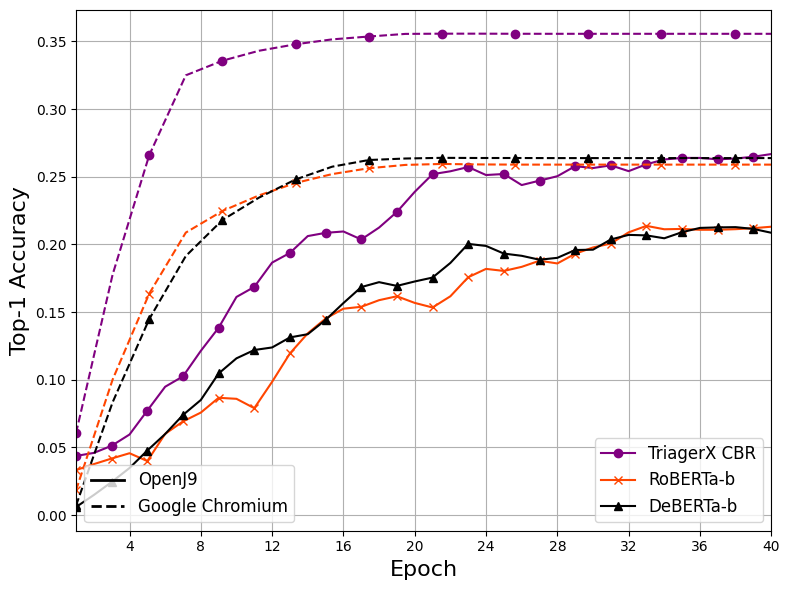

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.ticker as mticker
from scipy.interpolate import interp1d
import matplotlib.lines as mlines

# Load and preprocess the first dataset (OpenJ9)
df1 = pd.read_csv("orthogonality.csv")
df1 = df1[["Step", "cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc", 
           "triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc", 
           "cnn_deberta-base_u3_50_classes_most_seed42 - val_acc"]]
df1["Step"] = df1["Step"] + 1
epochs1 = df1['Step']
u3c3_1 = savgol_filter(df1['cnn_roberta-base_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u2c2_1 = savgol_filter(df1['triagerx_ensemble_u3_50_classes_last_dev_seed42 - val_acc'], window_length=7, polyorder=2)
u1c1_1 = savgol_filter(df1['cnn_deberta-base_u3_50_classes_most_seed42 - val_acc'], window_length=7, polyorder=2)

# Load and preprocess the second dataset (Google Chromium)
df2 = pd.read_csv("gc_base_models.csv")
df2 = df2[["Step", "cnn_roberta_base_dt_gc_th20_block9_seed42 - val_acc", 
           "triagerx_nosampler_ensemble_dt_gc_th20_block9_seed42 - val_acc", 
           "cnn_deberta_base_dt_gc_th20_block9_seed42 - val_acc"]]
df2["Step"] = df2["Step"] + 1

# Rescale Google Chromium dataset to match 40 epochs
epochs2_orig = df2["Step"]
epochs2_rescaled = np.linspace(1, 40, num=len(epochs2_orig))

# Interpolate values to stretch them across 40 epochs
interpolate = lambda y: interp1d(epochs2_orig, y, kind='linear', fill_value=(y.iloc[-1], y.iloc[-1]), bounds_error=False)(epochs2_rescaled)
u3c3_2 = savgol_filter(interpolate(df2['cnn_roberta_base_dt_gc_th20_block9_seed42 - val_acc']), window_length=7, polyorder=2)
u2c2_2 = savgol_filter(interpolate(df2['triagerx_nosampler_ensemble_dt_gc_th20_block9_seed42 - val_acc']), window_length=7, polyorder=2)
u1c1_2 = savgol_filter(interpolate(df2['cnn_deberta_base_dt_gc_th20_block9_seed42 - val_acc']), window_length=7, polyorder=2)

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot OpenJ9 dataset (solid lines)
l1, = ax.plot(epochs1, u2c2_1, linestyle='-', color="purple", marker='o', markevery=2, label='TriagerX CBR')
l2, = ax.plot(epochs1, u3c3_1, linestyle='-', color="orangered", marker='x', markevery=2, label='RoBERTa-b')
l3, = ax.plot(epochs1, u1c1_1, linestyle='-', color="black", marker='^', markevery=2, label='DeBERTa-b')

# Plot Google Chromium dataset (dashed lines)
l4, = ax.plot(epochs2_rescaled, u2c2_2, linestyle='--', color="purple", marker='o', markevery=2)
l5, = ax.plot(epochs2_rescaled, u3c3_2, linestyle='--', color="orangered", marker='x', markevery=2)
l6, = ax.plot(epochs2_rescaled, u1c1_2, linestyle='--', color="black", marker='^', markevery=2)

# Labels and title
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('Top-1 Accuracy', fontsize=16)
ax.set_xlim(1, 40)
ax.grid(True)

# Integer ticks on x-axis
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

openj9_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label='OpenJ9')
gc_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label='Google Chromium')

# Create two legends
legend1 = ax.legend([l1, l2, l3], ['TriagerX CBR', 'RoBERTa-b', 'DeBERTa-b'], loc='lower right', fontsize=12)
legend2 = ax.legend([openj9_line, gc_line], ['OpenJ9', 'Google Chromium'], loc='lower left', fontsize=12)
ax.add_artist(legend1)  # Ensure both legends are displayed

# Save and show the plot
plt.tight_layout()
plt.savefig('combined_top-1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [65]:
import pandas as pd
time_factor_df = pd.read_csv("time_factor.csv")
time_factor_df = time_factor_df.sort_values(by="time_decay_factor", ascending=True)

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

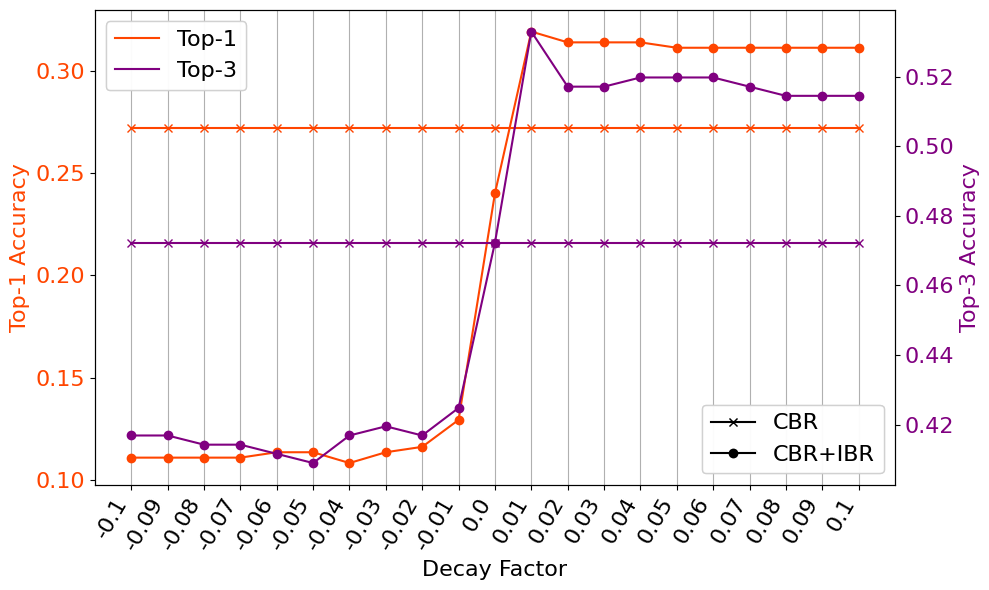

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Ensure you replace 'time_factor_df' with your actual DataFrame variable name
# Process the data (select columns)
time_factor = time_factor_df['time_decay_factor'].tolist()
t1dl = time_factor_df["T1DL"].tolist()
t1 = time_factor_df["T1Com"].tolist()
t3dl = time_factor_df["T3DL"].tolist()
t3 = time_factor_df["T3Com"].tolist()

# Set font preferences
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Top-1 accuracy on primary y-axis with different markers
ax1.plot(time_factor, t1, color='orangered', marker='o', label='Top-1')
ax1.plot(time_factor, t1dl, color='orangered', marker='x', label='Top-1DL')
ax1.set_xlabel('Decay Factor', fontsize=16)
ax1.set_ylabel('Top-1 Accuracy', fontsize=16, color='orangered')
ax1.tick_params(axis='y', labelcolor='orangered')

# Create a secondary y-axis for Top-3 accuracy with different markers
ax2 = ax1.twinx()
ax2.plot(time_factor, t3, color='purple', marker='o', label='Top-3')
ax2.plot(time_factor, t3dl, color='purple', marker='x', label='Top-3DL')
ax2.set_ylabel('Top-3 Accuracy', fontsize=16, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Customize the plot
ax1.set_xlabel('Decay Factor', fontsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

# Set x-axis tick positions and labels
ax1.set_xticks(time_factor)
ax1.set_xticklabels([str(tf) for tf in time_factor], rotation=60, ha='right')

# Show only vertical grid lines
ax1.grid(True, axis='x')
ax1.grid(False, axis='y')

ax2.grid(False, axis='x')
ax2.grid(False, axis='y')

# Create proxy artists for the legends
top1_line = mlines.Line2D([], [], color='orangered', label='Top-1')
top3_line = mlines.Line2D([], [], color='purple', label='Top-3')
cbr_line = mlines.Line2D([], [], color='black', marker='x', label='CBR')
cbr_cob_line = mlines.Line2D([], [], color='black', marker='o', label='CBR+IBR')

# Create legends for each set of markers separately
legend1 = ax1.legend(handles=[top1_line, top3_line], loc='upper left', fontsize=16)
legend2 = ax2.legend(handles=[cbr_line, cbr_cob_line], loc='lower right', fontsize=16)

# Add the legends to the plot
ax1.add_artist(legend1)
ax2.add_artist(legend2)

# Adjust layout and save/show the plot
plt.tight_layout()

plt.savefig('openj9-decay-factor.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

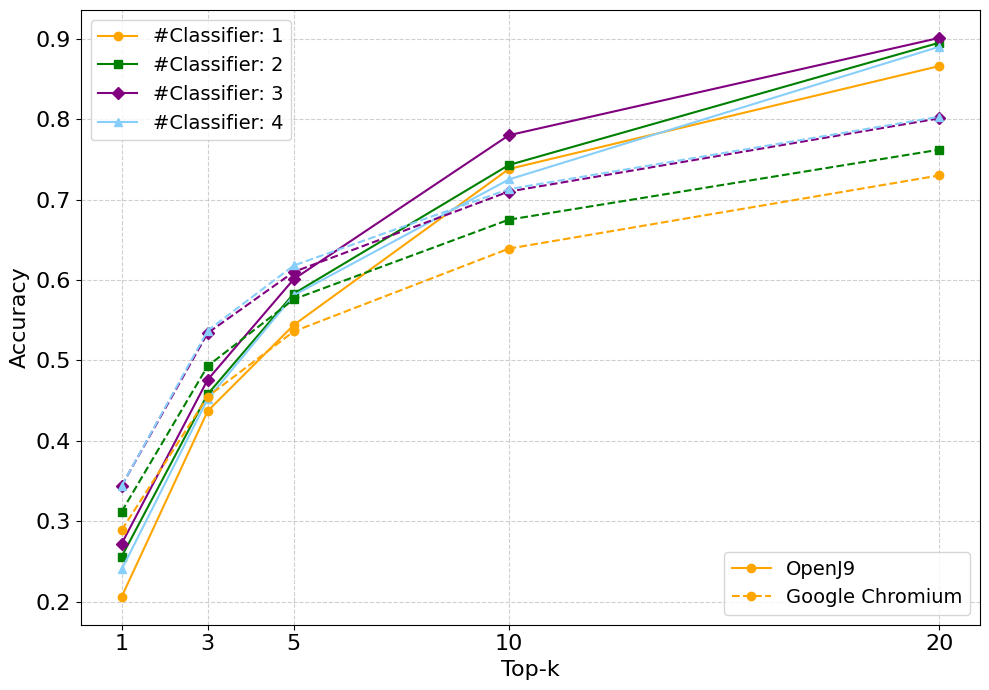

In [23]:
openj9 = {
    "1": [0.206, 0.437, 0.544, 0.738, 0.866],
    "2": [0.256, 0.458, 0.583, 0.743, 0.895],
    "3": [0.272, 0.476, 0.601, 0.780, 0.901],
    "4": [0.240, 0.452, 0.581, 0.725, 0.890]
    }

gc = {
    "1": [0.289, 0.455, 0.536, 0.639, 0.730],
    "2": [0.312, 0.493, 0.576, 0.675, 0.762],
    "3": [0.344, 0.534, 0.610, 0.710, 0.801],
    "4": [0.344, 0.537, 0.618, 0.713, 0.803]
}

# Create a line chart from these two different datasets and the topk (1-5) accuracy for different number of classifiers
import matplotlib.pyplot as plt
import numpy as np

def plot_topk_accuracy(openj9, gc):
    topk = [1, 3, 5, 10, 20]  # Explicitly setting top-k values
    colors = ['orange', 'green', 'purple', 'lightskyblue']  # Define distinct colors
    markers = ['o', 's', 'D', '^']  # Define distinct markers
    
    plt.figure(figsize=(10, 7))
    
    openj9_lines = []
    gc_lines = []
    classifier_labels = []
    
    for idx, (classifiers, acc) in enumerate(openj9.items()):
        line, = plt.plot(topk, acc, marker=markers[idx % len(markers)], linestyle='-', color=colors[idx % len(colors)])
        openj9_lines.append(line)
        classifier_labels.append(f'#Classifier: {classifiers}')
    
    for idx, (classifiers, acc) in enumerate(gc.items()):
        line, = plt.plot(topk, acc, marker=markers[idx % len(markers)], linestyle='--', color=colors[idx % len(colors)])
        gc_lines.append(line)
    
    dataset_legend = plt.legend([openj9_lines[0], gc_lines[0]], ['OpenJ9', 'Google Chromium'], fontsize=14, loc='lower right')
    plt.gca().add_artist(dataset_legend)
    classifier_legend = plt.legend(openj9_lines, classifier_labels, fontsize=14, loc='upper left')
    
    plt.xticks(topk, fontsize=16)  # Set xticks size
    plt.yticks(fontsize=16)  # Set yticks size
    plt.xlabel("Top-k", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    # plt.title("Top-k Accuracy for OpenJ9 and GC", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('classifier-vs-topk.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()



plot_topk_accuracy(openj9, gc)
